In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from sklearn.metrics import mean_squared_error
import os
import sys
import pickle
import itertools
import matplotlib.pyplot as plt

sys.path.append('../Models')
sys.path.append('../')

import wrmf, wrmf_helpers
import evaluation
from settings import PATH_TO_SPARSE_MATRIX

## Get the song factorization 

In [2]:
with open('../Models/wrmf_factors.pickle', 'rb') as f:
    playlist_factors, song_factors = pickle.load(f)

print(song_factors.shape)
print(playlist_factors.shape)

(2029866, 20)
(800000, 20)


# Compute percentages of playlists returned for 3 stage 1 models

In [3]:
test_playlists = []
for i in range(800, 810):
    filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
    cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
    df = pd.read_csv(filename).drop(columns = cols_ignore)
    test_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

_, tid_to_idx, _, _, _ = wrmf_helpers.get_user_item_sparse_matrix(PATH_TO_SPARSE_MATRIX)    

In [4]:
# """
# Use precomputed results from data/viz_data
# """  
    
output_sizes = [500, 1000, 5000, 10000, 15000, 20000, 30000]
song_to_song = {size: [] for size in output_sizes}
playlist_to_song = {size: [] for size in output_sizes}
ensemble = {size: [] for size in output_sizes}

for i, test_playlist in enumerate(test_playlists[:30]):
    test_playlist = test_playlist.str.replace('spotify:track:', '')
    n = len(test_playlist)
    test_playlist_set = set(test_playlist)
    seed_ids = []
    while len(seed_ids) < 2:
        rand =list(test_playlist.sample(n=1))[0]
        if rand in tid_to_idx:
            seed_ids.append(rand)
    for output_size in output_sizes:
        print(i, output_size)
        song_to_song_matches = wrmf_helpers.get_top_similar_from_tracks(
            song_factors,
            seed_ids,
            n_similar=output_size,
            verbose=False
        )
        song_to_song[output_size].append(len(test_playlist_set.intersection(set(song_to_song_matches)))/n)

        playlist_to_song_matches = wrmf_helpers.get_top_similar_from_playlists(
            song_factors,
            playlist_factors,
            seed_ids,
            n_similar_songs=output_size,
            n_similar_playlists=200
        )
        playlist_to_song[output_size].append(len(test_playlist_set.intersection(set(playlist_to_song_matches)))/n)

        ensemble_matches = wrmf_helpers.get_top_similar_from_ensemble(
            song_factors,
            playlist_factors,
            seed_ids,
            n_similar_songs=output_size,
            n_similar_playlists=200
        )
        ensemble[output_size].append(len(test_playlist_set.intersection(set(ensemble_matches)))/n)

with open('../data/viz_data/wrmf_models_results.pickle', 'wb') as fd:
    pickle.dump((song_to_song, playlist_to_song, ensemble), fd)

0 500
0 1000
0 5000
0 10000
0 15000
0 20000
0 30000
1 500
1 1000
1 5000
1 10000
1 15000
1 20000
1 30000
2 500
2 1000
2 5000
2 10000
2 15000
2 20000
2 30000
3 500
3 1000
3 5000
3 10000
3 15000
3 20000
3 30000
4 500
4 1000
4 5000
4 10000
4 15000
4 20000
4 30000
5 500
5 1000
5 5000
5 10000
5 15000
5 20000
5 30000
6 500
6 1000
6 5000
6 10000
6 15000
6 20000
6 30000
7 500
7 1000
7 5000
7 10000
7 15000
7 20000
7 30000
8 500
8 1000
8 5000
8 10000
8 15000
8 20000
8 30000
9 500
9 1000
9 5000
9 10000
9 15000
9 20000
9 30000
10 500
10 1000
10 5000
10 10000
10 15000
10 20000
10 30000
11 500
11 1000
11 5000
11 10000
11 15000
11 20000
11 30000
12 500
12 1000
12 5000
12 10000
12 15000
12 20000
12 30000
13 500
13 1000
13 5000
13 10000
13 15000
13 20000
13 30000
14 500
14 1000
14 5000
14 10000
14 15000
14 20000
14 30000
15 500
15 1000
15 5000
15 10000
15 15000
15 20000
15 30000
16 500
16 1000
16 5000
16 10000
16 15000
16 20000
16 30000
17 500
17 1000
17 5000
17 10000
17 15000
17 20000
17 30000
18 500
1

In [6]:
output_sizes = [500, 1000, 5000, 10000, 15000, 20000, 30000]

with open('../data/viz_data/wrmf_models_results.pickle', 'rb') as f:
    song_to_song, playlist_to_song, ensemble = pickle.load(f)

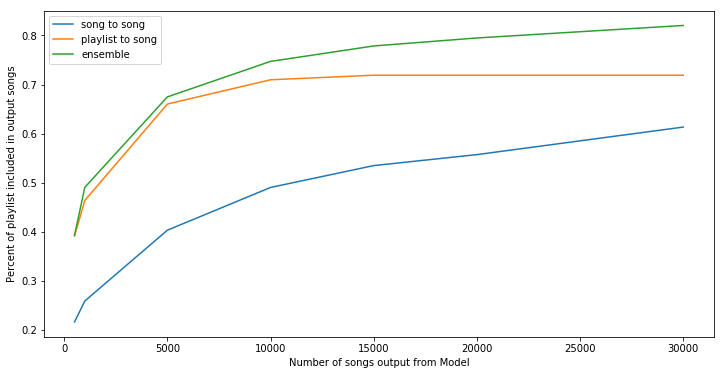

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
x = output_sizes
ax.plot(x, [np.array(v).mean() for v in song_to_song.values()], label='song to song')
ax.plot(x, [np.array(v).mean() for v in playlist_to_song.values()], label='playlist to song')
ax.plot(x, [np.array(v).mean() for v in ensemble.values()], label='ensemble')
ax.legend()

ax.set_xlabel("Number of songs output from Model")
ax.set_ylabel("Percent of playlist included in output songs")

plt.show()

# Compute average "clicks"

In [8]:
"""
Use precomputed results from data/viz_data
"""   

song_to_song_clicks = []
playlist_to_song_clicks = []
ensemble_clicks = []

for i, test_playlist in enumerate(test_playlists[:50]):
    print(i)
    test_playlist = test_playlist.str.replace('spotify:track:', '')
    seed_ids = []
    while len(seed_ids) < 2:
        rand =list(test_playlist.sample(n=1))[0]
        if rand in tid_to_idx:
            seed_ids.append(rand)

    song_to_song_matches = wrmf_helpers.get_top_similar_from_tracks(
        song_factors,
        seed_ids,
        n_similar=20000,
        verbose=False
    )
    song_to_song_clicks.append(
        evaluation.eval_clicks(test_playlist, song_to_song_matches, seed_ids)
    )
                
                
    playlist_to_song_matches = wrmf_helpers.get_top_similar_from_playlists(
        song_factors,
        playlist_factors,
        seed_ids,
        n_similar_songs=20000,
        n_similar_playlists=200
    )
    playlist_to_song_clicks.append(
        evaluation.eval_clicks(test_playlist, playlist_to_song_matches, seed_ids)
    )
    
    ensemble_matches = wrmf_helpers.get_top_similar_from_ensemble(
        song_factors,
        playlist_factors,
        seed_ids,
        n_similar_songs=20000,
        n_similar_playlists=200
    )
    ensemble_clicks.append(
        evaluation.eval_clicks(test_playlist, ensemble_matches, seed_ids)
    )

with open('../data/viz_data/wrmf_songclick_results.pickle', 'wb') as fd:
    pickle.dump((song_to_song_clicks, playlist_to_song_clicks, ensemble_clicks), fd)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
with open('../data/viz_data/wrmf_songclick_results.pickle', 'rb') as fd:
    song_to_song_clicks, playlist_to_song_clicks, ensemble_clicks = pickle.load(fd)

Average clicks for song to song: 17.44
Median clicks for song to song: 2.0


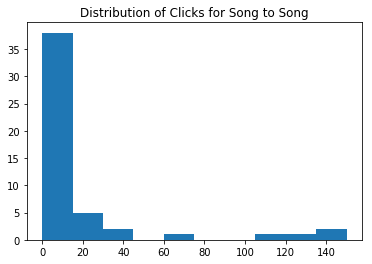

In [10]:
song_to_song_clicks = pd.Series(song_to_song_clicks).replace([np.inf, -np.inf], np.nan).dropna()
print(f"Average clicks for song to song: {song_to_song_clicks.mean()}")
print(f"Median clicks for song to song: {song_to_song_clicks.median()}")
plt.hist(song_to_song_clicks)
plt.title("Distribution of Clicks for Song to Song")
plt.show()

Average clicks for playlist to song: 1336.26
Median clicks for playlist to song: 1311.5


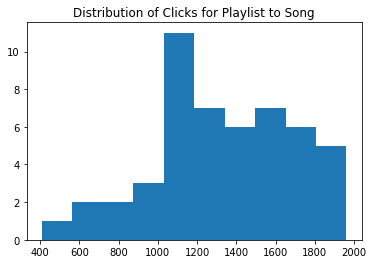

In [11]:
playlist_to_song_clicks = pd.Series(playlist_to_song_clicks).replace([np.inf, -np.inf], np.nan).dropna()
print(f"Average clicks for playlist to song: {playlist_to_song_clicks.mean()}")
print(f"Median clicks for playlist to song: {playlist_to_song_clicks.median()}")
plt.hist(playlist_to_song_clicks)
plt.title("Distribution of Clicks for Playlist to Song")
plt.show()

Average clicks for ensemble: 720.14
Median clicks for ensemble: 580.0


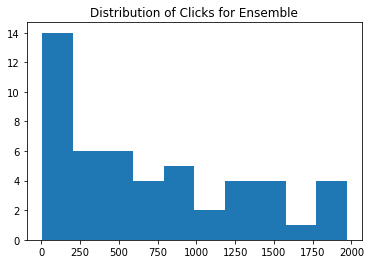

In [12]:
ensemble_clicks = pd.Series(ensemble_clicks).replace([np.inf, -np.inf], np.nan).dropna()
print(f"Average clicks for ensemble: {ensemble_clicks.mean()}")
print(f"Median clicks for ensemble: {ensemble_clicks.median()}")
plt.hist(ensemble_clicks)
plt.title("Distribution of Clicks for Ensemble")
plt.show()